<a href="https://colab.research.google.com/github/jhonaraujos/TCC_UNDB/blob/main/PREDI%C3%87%C3%83O_%2B_VALIDA%C3%87%C3%83O_DA_RODA_INDIVIDUAL___TCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pycaret

  Using cached pycaret-3.3.2-py3-none-any.whl (486 kB)
  Using cached joblib-1.3.2-py3-none-any.whl (302 kB)
  Using cached scikit_learn-1.5.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)
  Using cached pyod-1.1.3.tar.gz (160 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 41.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 M

In [ ]:
import pandas as pd
from datetime import datetime

# Carregar os dados do CSV
df_original = pd.read_csv("/content/EVO - Degradaçao de Largura de Friso.csv", delimiter=';')

# Selecionar as colunas desejadas
colunas_desejadas = ["Train Time", "Vehicle Tag", "Vehicle Axle Number", "Side of Vehicle", "Site",  "Flange Thickness (mm)", "Flange Thickness Confidence",
"Flange Height (mm)", "Flange Height Confidence", "Rim Thickness (mm)", "Rim Thickness Confidence","Tread Hollow (mm)","Tread Hollow Confidence","Flange Slope (mm)", "BTB (mm)", "Wheel Diameter (mm)", "Rail Dist (mm)"]
df_original= df_original[colunas_desejadas]

# Remover duplicatas considerando todas as colunas
df_original = df_original.drop_duplicates()

# Filtrar o DataFrame para manter apenas as linhas onde "Flange Thickness (mm)" não é vazio e com medida com confiança e somente da Linha 1
df = df_original.loc[df_original["Site"] != "16K888 Lina 3"].copy()

# Criar a coluna "Date REF" com AM ou PM e remover AM/PM da coluna "Train Time"
df["Date REF"] = df["Train Time"].str.extract(r'(\bAM\b|\bPM\b)', expand=False)
df["Train Time"] = df["Train Time"].str.replace(r'\s*(AM|PM)\b', '', regex=True)

# Função para converter o formato de data/hora
def converter_train_time(data_hora, date_ref):
    try:
        if date_ref in ['AM', 'PM']:
            # Tentar converter datas no formato com AM/PM
            data_hora = datetime.strptime(data_hora, '%m/%d/%Y %I:%M:%S')
            if date_ref == 'PM' and data_hora.hour != 12:
                data_hora = data_hora.replace(hour=data_hora.hour + 12)
            elif date_ref == 'AM' and data_hora.hour == 12:
                data_hora = data_hora.replace(hour=0)
        else:
            # Tentar converter datas no formato padrão sem AM/PM
            try:
                data_hora = datetime.strptime(data_hora, '%m/%d/%Y %H:%M')
            except ValueError:
                data_hora = datetime.strptime(data_hora, '%m/%d/%Y %H:%M:%S')
        return data_hora  # Retorna como objeto datetime
    except ValueError:
        return None

# Converter o formato de "Train Time"
df["Train Time"] = df.apply(lambda row: converter_train_time(row["Train Time"], row["Date REF"]), axis=1)

# Garantir que 'Train Time' é datetime para ordenação correta
df['Train Time'] = pd.to_datetime(df['Train Time'], errors='coerce')  # Converte para datetime e trata erros

# Criar a coluna "id" com a junção das colunas Numero do veiculo + Numero do Rodeiro + Lado do Rodeiro (L = LEFT , R = RIGHT)
df["id"] = df["Vehicle Tag"] + "_" + df["Vehicle Axle Number"].astype(str) + "_" + df["Side of Vehicle"]

# Ordenar o DataFrame por "Train Time" em ordem crescente e depois por "Vehicle Axle Number"
df = df.sort_values(by=["Train Time", "Vehicle Axle Number"], ascending=[True, True])

# Criar a coluna "passagem" que conta sequencialmente cada valor único na coluna "id"
df["passagem"] = df.groupby('id').cumcount() + 1

# Ordenar novamente para exibir na ordem correta das passagens de forma crescente
df = df.sort_values(by=["id", "passagem"])
# Salvar o DataFrame filtrado em um novo arquivo CSV na pasta de saída

df

,Train Time,Vehicle Tag,Vehicle Axle Number,Side of Vehicle,Site,Flange Thickness (mm),Flange Thickness Confidence,Flange Height (mm),Flange Height Confidence,Rim Thickness (mm),Rim Thickness Confidence,Tread Hollow (mm),Tread Hollow Confidence,Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm),Date REF,id,passagem
19452,2023-07-17 23:02:08,EVO 2001,1,L,16K888 Lina 1,25.4,Yes,30.1,Yes,29.4,Yes,0.0,Yes,1.5,1515.7,1002.0,44.3,PM,EVO 2001_1_L,1
16716,2023-07-23 07:52:43,EVO 2001,1,L,16K888 Lina 1,25.4,Yes,30.3,Yes,29.2,Yes,0.0,Yes,2.6,1516.1,1001.0,44.7,AM,EVO 2001_1_L,2
16260,2023-07-24 07:22:45,EVO 2001,1,L,16K888 Lina 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AM,EVO 2001_1_L,3
15456,2023-07-27 12:50:55,EVO 2001,1,L,16K888 Lina 1,25.4,Yes,30.3,Yes,29.7,Yes,0.0,Yes,1.5,1515.3,1001.0,45.2,PM,EVO 2001_1_L,4
13920,2023-07-31 01:47:02,EVO 2001,1,L,16K888 Lina 1,25.3,Yes,30.4,Yes,29.4,Yes,0.0,Yes,1.4,1516.8,1000.0,42.2,AM,EVO 2001_1_L,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25911,2024-04-20 06:12:06,EVO 298,6,R,16K888 Lina 1,30.9,Yes,29.0,Yes,64.0,Yes,0.9,Yes,1.9,1516.3,1073.0,44.7,AM,EVO 298_6_R,79
78243,2024-05-01 12:39:00,EVO 298,6,R,16K888 Lina 1,31.4,Yes,29.4,Yes,63.6,Yes,0.5,Yes,2.0,1517.9,1070.0,42.9,NaN,EVO 298_6_R,80
22491,2024-05-15 06:42:37,EVO 298,6,R,16K888 Lina 1,27.1,Yes,29.1,Yes,63.4,Yes,0.4,No,5.4,1518.2,1071.0,43.3,AM,EVO 298_6_R,81
21639,2024-05-19 06:22:07,EVO 298,6,R,16K888 Lina 1,31.2,Yes,29.7,Yes,63.3,Yes,0.3,Yes,1.7,1517.9,1066.0,43.0,AM,EVO 298_6_R,82


In [ ]:
#ANALISE EXPLORATÓRIA ANTES PARA ENTENDIMENTO DAS AÇÕES DE MINIMIZAR OS RUÍDOS E FALSOS POSITIVOS

# Contagem do número total de IDs únicos
total_unique_ids = df['id'].nunique()

# Contagem do número de IDs com menos de 60 ocorrências
id_counts = df['id'].value_counts()
id_less_than_60 = (id_counts < 60).sum()

# Obter os 10 IDs mais frequentes
top_10_most = id_counts.head(10)

# Contar valores em branco na coluna 'Flange Thickness (mm)'
flange_thickness_na = df['Flange Thickness (mm)'].isna().sum()

# Contar valores 'No' na coluna 'Flange Thickness Confidence'
flange_thickness_no = (df['Flange Thickness Confidence'] == 'No').sum()

# Contar valores '16K888 Lina 2' na coluna 'Site'
site_16k888_lina2 = (df['Site'] == '16K888 Lina 2').sum()

# Preparar o resultado como um dicionário
result = {
    "Total ids": total_unique_ids,
    "ids menor que 60 passagens": id_less_than_60,
    "Top 10 ids com mais linhas": top_10_most.to_dict(),
    "Valores em branco na coluna 'Flange Thickness (mm)'": flange_thickness_na,
    "Valores 'No' na coluna 'Flange Thickness Confidence'": flange_thickness_no,
    "Valores na coluna 'Site' == '16K888 Lina 2'": site_16k888_lina2
}

result


{'Total ids': 1164,
 'ids menor que 60 passagens': 48,
 'Top 10 ids com mais linhas': {'EVO 227_4_L': 113,
  'EVO 227_1_R': 113,
  'EVO 227_4_R': 113,
  'EVO 227_3_R': 113,
  'EVO 227_3_L': 113,
  'EVO 227_2_R': 113,
  'EVO 227_2_L': 113,
  'EVO 227_1_L': 113,
  'EVO 227_6_R': 112,
  'EVO 227_5_L': 112},
 "Valores em branco na coluna 'Flange Thickness (mm)'": 3631,
 "Valores 'No' na coluna 'Flange Thickness Confidence'": 1218,
 "Valores na coluna 'Site' == '16K888 Lina 2'": 2988}

In [ ]:
import pandas as pd

# Reordenar o dataframe por 'id' e 'passagem' em ordem crescente para facilitar o preenchimento
df_sorted = df.sort_values(by=['id', 'passagem'], ascending=[True, True])

# Lista de colunas para aplicar a lógica de preenchimento
columns_to_fill = ["Flange Thickness (mm)", "Flange Height (mm)", "Rim Thickness (mm)",
                   "Tread Hollow (mm)", "Flange Slope (mm)", "BTB (mm)", "Wheel Diameter (mm)", "Rail Dist (mm)"]

# Função para preencher os valores nulos com a média dos últimos 3 valores anteriores, incluindo os valores substituídos
def fill_na_with_mean(group):
    for column in columns_to_fill:
        filled_values = group[column].copy()
        for i in range(len(filled_values)):
            if pd.isna(filled_values.iloc[i]):
                # Pegar os últimos 3 valores anteriores
                previous_values = filled_values.iloc[max(0, i-3):i]
                if not previous_values.empty:
                    mean_value = previous_values.mean()
                else:
                    # Se não houver valores anteriores, usar o próximo valor não nulo
                    mean_value = filled_values.iloc[i+1:].dropna().iloc[0]
                filled_values.iloc[i] = mean_value
        group[column] = filled_values
    return group

# Aplicar a função para cada grupo de 'id'
df_filled = df_sorted.groupby('id', group_keys=False).apply(fill_na_with_mean)

# Função para arredondar para baixo para uma casa decimal
def round_down_one_decimal(value):
    return (value * 10 // 1) / 10

# Aplicar a função de arredondamento para as colunas selecionadas
for column in columns_to_fill:
    df_filled[column] = df_filled[column].apply(round_down_one_decimal)

# Verificação para um ID específico
specific_id = 'EVO 2001_1_L'
original_na_specific = df[(df['id'] == specific_id) & (df[columns_to_fill].isna().any(axis=1))]
filled_na_specific_corrected = df_filled[(df_filled['id'] == specific_id) & (df_filled.index.isin(original_na_specific.index))]

original_na_specific_output = original_na_specific[['id', 'passagem'] + columns_to_fill]
filled_na_specific_corrected_output = filled_na_specific_corrected[['id', 'passagem'] + columns_to_fill]

display(original_na_specific_output, filled_na_specific_corrected_output)


,id,passagem,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm)
16260,EVO 2001_1_L,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13680,EVO 2001_1_L,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5088,EVO 2001_1_L,22,23.8,31.1,27.9,0.3,0.8,1517.0,NaN,41.7
57228,EVO 2001_1_L,26,32.3,28.4,NaN,0.0,1.5,1519.1,NaN,42.3
90062,EVO 2001_1_L,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38868,EVO 2001_1_L,55,29.3,27.5,35.8,0.0,2.0,1517.4,NaN,49.0
37704,EVO 2001_1_L,57,29.3,27.3,35.3,0.0,1.2,1518.2,NaN,49.9
76756,EVO 2001_1_L,59,29.4,27.3,35.3,0.0,0.5,1517.0,NaN,50.5
71536,EVO 2001_1_L,60,28.9,27.4,35.0,0.0,1.1,1517.7,NaN,50.7
66132,EVO 2001_1_L,61,28.6,27.3,NaN,0.0,2.0,1516.4,NaN,51.3


,id,passagem,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm)
16260,EVO 2001_1_L,3,25.4,30.2,29.3,0.0,2.0,1515.9,1001.5,44.5
13680,EVO 2001_1_L,6,25.3,30.3,29.4,0.0,1.6,1516.0,1000.8,43.9
5088,EVO 2001_1_L,22,23.8,31.1,27.9,0.3,0.8,1517.0,995.3,41.7
57228,EVO 2001_1_L,26,32.3,28.4,27.6,0.0,1.5,1519.1,995.0,42.3
90062,EVO 2001_1_L,36,31.1,28.6,35.7,0.0,2.2,1516.2,1010.6,45.8
38868,EVO 2001_1_L,55,29.3,27.5,35.8,0.0,2.0,1517.4,1010.3,49.0
37704,EVO 2001_1_L,57,29.3,27.3,35.3,0.0,1.2,1518.2,1010.4,49.9
76756,EVO 2001_1_L,59,29.4,27.3,35.3,0.0,0.5,1517.0,1009.1,50.5
71536,EVO 2001_1_L,60,28.9,27.4,35.0,0.0,1.1,1517.7,1008.8,50.7
66132,EVO 2001_1_L,61,28.6,27.3,35.1,0.0,2.0,1516.4,1008.3,51.3


In [ ]:


# Lista de colunas para aplicar a lógica de preenchimento
columns_to_fill = ["Flange Thickness (mm)", "Flange Height (mm)", "Rim Thickness (mm)",
                   "Tread Hollow (mm)", "Flange Slope (mm)", "BTB (mm)", "Wheel Diameter (mm)", "Rail Dist (mm)"]

# Função para preencher os valores com a média dos últimos 3 valores anteriores, incluindo os valores substituídos, quando o 'Site' for '16K888 Lina 2'
def fill_with_mean_for_specific_site(group):
    for column in columns_to_fill:
        filled_values = group[column].copy()
        for i in range(len(filled_values)):
            if group.iloc[i]['Site'] == '16K888 Lina 2':
                # Pegar os últimos 3 valores anteriores
                previous_values = filled_values.iloc[max(0, i-3):i]
                if not previous_values.empty:
                    mean_value = previous_values.mean()
                else:
                    # Se não houver valores anteriores, usar o próximo valor não nulo
                    mean_value = filled_values.iloc[i+1:].dropna().iloc[0]
                filled_values.iloc[i] = mean_value
        group[column] = filled_values
    return group

# Aplicar a função para cada grupo de 'id' na base já tratada pelo primeiro código
df_filled_site_specific = df_filled.groupby('id', group_keys=False).apply(fill_with_mean_for_specific_site)

# Função para arredondar para baixo para uma casa decimal
def round_down_one_decimal(value):
    return (value * 10 // 1) / 10

# Aplicar a função de arredondamento para as colunas selecionadas
for column in columns_to_fill:
    df_filled_site_specific[column] = df_filled_site_specific[column].apply(round_down_one_decimal)

# Verificação para um ID específico
specific_id = 'EVO 2001_1_L'
original_na_specific_site = df_filled[(df_filled['id'] == specific_id) & (df_filled['Site'] == '16K888 Lina 2')]
filled_na_specific_corrected_site = df_filled_site_specific[(df_filled_site_specific['id'] == specific_id) & (df_filled_site_specific['Site'] == '16K888 Lina 2') & (df_filled_site_specific.index.isin(original_na_specific_site.index))]

original_na_specific_site_output = original_na_specific_site[['id', 'passagem', 'Site'] + columns_to_fill]
filled_na_specific_corrected_site_output = filled_na_specific_corrected_site[['id', 'passagem', 'Site'] + columns_to_fill]

display(original_na_specific_site_output, filled_na_specific_corrected_site_output)



,id,passagem,Site,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm)
16260,EVO 2001_1_L,3,16K888 Lina 2,25.4,30.2,29.3,0.0,2.0,1515.9,1001.5,44.5
13680,EVO 2001_1_L,6,16K888 Lina 2,25.3,30.3,29.4,0.0,1.6,1516.0,1000.8,43.9
90062,EVO 2001_1_L,36,16K888 Lina 2,31.1,28.6,35.7,0.0,2.2,1516.2,1010.6,45.8


,id,passagem,Site,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm)
16260,EVO 2001_1_L,3,16K888 Lina 2,25.4,30.2,29.3,0.0,2.0,1515.9,1001.5,44.5
13680,EVO 2001_1_L,6,16K888 Lina 2,25.3,30.3,29.4,0.0,1.6,1516.0,1000.8,43.9
90062,EVO 2001_1_L,36,16K888 Lina 2,31.1,28.6,35.7,0.0,2.2,1516.2,1010.6,45.8


In [ ]:
import pandas as pd

# Lista de colunas para aplicar a lógica de preenchimento
columns_to_fill = ["Flange Thickness (mm)", "Flange Height (mm)", "Rim Thickness (mm)",
                   "Tread Hollow (mm)", "Flange Slope (mm)", "BTB (mm)", "Wheel Diameter (mm)", "Rail Dist (mm)"]

# Função para preencher os valores com a média dos últimos 3 valores anteriores, incluindo os valores substituídos, quando o 'Flange Thickness Confidence' for 'No'
def fill_with_mean_for_confidence_no(group):
    for column in columns_to_fill:
        filled_values = group[column].copy()
        for i in range(len(filled_values)):
            if group.iloc[i]['Flange Thickness Confidence'] == 'No':
                # Pegar os últimos 3 valores anteriores
                previous_values = filled_values.iloc[max(0, i-3):i]
                if not previous_values.empty:
                    mean_value = previous_values.mean()
                else:
                    # Se não houver valores anteriores, usar o próximo valor não nulo
                    mean_value = filled_values.iloc[i+1:].dropna().iloc[0]
                filled_values.iloc[i] = mean_value
        group[column] = filled_values
    return group

# Aplicar a função para cada grupo de 'id' na base já tratada pelos dois códigos anteriores
df_filled_confidence_no = df_filled_site_specific.groupby('id', group_keys=False).apply(fill_with_mean_for_confidence_no)

# Função para arredondar para baixo para uma casa decimal
def round_down_one_decimal(value):
    return (value * 10 // 1) / 10

# Aplicar a função de arredondamento para as colunas selecionadas
for column in columns_to_fill:
    df_filled_confidence_no[column] = df_filled_confidence_no[column].apply(round_down_one_decimal)

# Verificação para um ID específico e 'Flange Thickness Confidence' igual a 'No'
specific_id = 'EVO 2001_3_L'
original_na_specific_confidence = df_filled_site_specific[(df_filled_site_specific['id'] == specific_id) & (df_filled_site_specific['Flange Thickness Confidence'] == 'No')]
filled_na_specific_corrected_confidence = df_filled_confidence_no[(df_filled_confidence_no['id'] == specific_id) & (df_filled_confidence_no['Flange Thickness Confidence'] == 'No') & (df_filled_confidence_no.index.isin(original_na_specific_confidence.index))]

original_na_specific_confidence_output = original_na_specific_confidence[['id', 'passagem', 'Flange Thickness Confidence'] + columns_to_fill]
filled_na_specific_corrected_confidence_output = filled_na_specific_corrected_confidence[['id', 'passagem', 'Flange Thickness Confidence'] + columns_to_fill]

display(original_na_specific_confidence_output, filled_na_specific_corrected_confidence_output)


,id,passagem,Flange Thickness Confidence,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm)
27544,EVO 2001_3_L,85,No,29.5,30.1,32.3,2.2,1.4,1518.9,1006.0,37.2


,id,passagem,Flange Thickness Confidence,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm)
27544,EVO 2001_3_L,85,No,31.0,28.9,31.5,2.3,2.0,1515.4,1004.3,37.6


In [ ]:
# Salvar o dataframe final para continuar os tratamentos
df_final = df_filled_confidence_no

# Mostrar as primeiras linhas do dataframe final para verificação
df_final.head()

,Train Time,Vehicle Tag,Vehicle Axle Number,Side of Vehicle,Site,Flange Thickness (mm),Flange Thickness Confidence,Flange Height (mm),Flange Height Confidence,Rim Thickness (mm),Rim Thickness Confidence,Tread Hollow (mm),Tread Hollow Confidence,Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm),Date REF,id,passagem
19452,2023-07-17 23:02:08,EVO 2001,1,L,16K888 Lina 1,25.4,Yes,30.1,Yes,29.4,Yes,0.0,Yes,1.5,1515.7,1002.0,44.3,PM,EVO 2001_1_L,1
16716,2023-07-23 07:52:43,EVO 2001,1,L,16K888 Lina 1,25.4,Yes,30.3,Yes,29.2,Yes,0.0,Yes,2.6,1516.1,1001.0,44.7,AM,EVO 2001_1_L,2
16260,2023-07-24 07:22:45,EVO 2001,1,L,16K888 Lina 2,25.4,NaN,30.2,NaN,29.3,NaN,0.0,NaN,2.0,1515.9,1001.5,44.5,AM,EVO 2001_1_L,3
15456,2023-07-27 12:50:55,EVO 2001,1,L,16K888 Lina 1,25.4,Yes,30.3,Yes,29.7,Yes,0.0,Yes,1.5,1515.3,1001.0,45.2,PM,EVO 2001_1_L,4
13920,2023-07-31 01:47:02,EVO 2001,1,L,16K888 Lina 1,25.3,Yes,30.4,Yes,29.4,Yes,0.0,Yes,1.4,1516.8,1000.0,42.2,AM,EVO 2001_1_L,5


In [ ]:
# Verificar valores em branco nas colunas 'passagem' e 'Flange Thickness (mm)'
blank_passagem = df_final['passagem'].isna().sum()
blank_flange_thickness = df_final['Flange Thickness (mm)'].isna().sum()

print(f"Valores em branco na coluna 'passagem': {blank_passagem}")
print(f"Valores em branco na coluna 'Flange Thickness (mm)': {blank_flange_thickness}")

Valores em branco na coluna 'passagem': 0
Valores em branco na coluna 'Flange Thickness (mm)': 0


In [ ]:
# Reordenar o dataframe final por 'id' e 'passagem' em ordem crescente
df_final_sorted = df_final.sort_values(by=['id', 'passagem'], ascending=[True, True])

# Função para calcular a degradação da espessura da flange
def calculate_degradation(group):
    initial_value = group.iloc[0]['Flange Thickness (mm)']
    final_value = group.iloc[-1]['Flange Thickness (mm)']
    final_passagem = group.iloc[-1]['passagem']
    degradation = initial_value - final_value
    return pd.Series({
        'Initial Value': initial_value,
        'Final Value': final_value,
        'Final Passagem': final_passagem,
        'Degradation': degradation
    })

# Aplicar a função para cada grupo de 'id'
degradation_df_final = df_final_sorted.groupby('id').apply(calculate_degradation).reset_index()

# Ordenar os IDs pela maior degradação
degradation_df_final_sorted = degradation_df_final.sort_values(by='Degradation', ascending=False)

# Exibir os 10 IDs com a maior degradação
top_10_degradation_final = degradation_df_final_sorted.head(10)
top_10_degradation_final


,id,Initial Value,Final Value,Final Passagem,Degradation
583,EVO 250_4_R,31.9,23.9,87.0,8.0
576,EVO 250_1_L,33.0,26.0,87.0,7.0
153,EVO 213_5_R,33.8,26.8,87.0,7.0
109,EVO 2010_1_R,31.3,24.4,88.0,6.9
59,EVO 2005_6_R,31.7,24.8,59.0,6.9
577,EVO 250_1_R,32.2,25.4,87.0,6.8
859,EVO 273_4_R,27.0,20.2,96.0,6.8
84,EVO 2008_1_L,31.9,25.1,86.0,6.8
1009,EVO 286_1_R,31.7,25.0,76.0,6.7
25,EVO 2003_1_R,31.8,25.2,77.0,6.6


In [ ]:
# POR CONTA DE TROCAS DE RODEIROS O VALOR INICIAL MENOS O FINAL PODE TRAZER UM VALOR DE DEGRADATION ERRADO COMO NO EXEMPLO DA EVO 273_4_R QUE O REAL SERIA 32.8 - 20.2 = 12.6 DE DEGRADATION
# POR ISSO FOI NECESSÁRIO
# Reordenar o dataframe final por 'id' e 'passagem' em ordem crescente
df_final_sorted = df_final.sort_values(by=['id', 'passagem'], ascending=[True, True])

# Função para calcular a taxa média de degradação por passagem
def calculate_degradation_rate(group):
    initial_value = group.iloc[0]['Flange Thickness (mm)']
    final_value = group.iloc[-1]['Flange Thickness (mm)']
    num_passages = len(group)
    degradation = initial_value - final_value
    degradation_rate = degradation / num_passages
    return pd.Series({
        'Initial Value': initial_value,
        'Final Value': final_value,
        'Number of Passages': num_passages,
        'Degradation': degradation,
        'Degradation Rate': degradation_rate
    })

# Aplicar a função para cada grupo de 'id'
degradation_rate_df = df_final_sorted.groupby('id').apply(calculate_degradation_rate).reset_index()

# Ordenar os IDs pela maior taxa de degradação
degradation_rate_df_sorted = degradation_rate_df.sort_values(by='Degradation Rate', ascending=False)

# Exibir os 20 IDs com a maior taxa de degradação
top_20_degradation_rate = degradation_rate_df_sorted.head(20)
display(top_20_degradation_rate)


,id,Initial Value,Final Value,Number of Passages,Degradation,Degradation Rate
735,EVO 263_2_R,30.8,29.2,7.0,1.6,0.228571
739,EVO 263_4_R,29.5,28.5,7.0,1.0,0.142857
59,EVO 2005_6_R,31.7,24.8,59.0,6.9,0.116949
690,EVO 259_4_L,30.8,26.1,44.0,4.7,0.106818
684,EVO 259_1_L,30.9,26.5,44.0,4.4,0.100000
841,EVO 272_1_R,30.9,24.4,67.0,6.5,0.097015
583,EVO 250_4_R,31.9,23.9,87.0,8.0,0.091954
1009,EVO 286_1_R,31.7,25.0,76.0,6.7,0.088158
733,EVO 263_1_R,27.8,27.2,7.0,0.6,0.085714
25,EVO 2003_1_R,31.8,25.2,77.0,6.6,0.085714


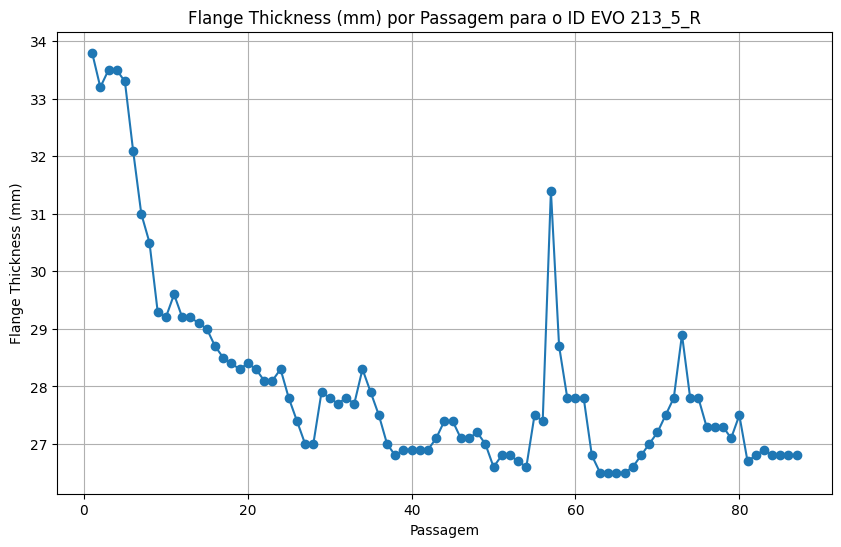

In [ ]:
import matplotlib.pyplot as plt

# Definir o ID específico que deseja plotar
specific_id = 'EVO 213_5_R'

# Filtrar o dataframe final para o ID específico
df_specific = df_final[df_final['id'] == specific_id]

# Plotar Flange Thickness (mm) por passagem
plt.figure(figsize=(10, 6))
plt.plot(df_specific['passagem'], df_specific['Flange Thickness (mm)'], marker='o', linestyle='-')
plt.title(f'Flange Thickness (mm) por Passagem para o ID {specific_id}')
plt.xlabel('Passagem')
plt.ylabel('Flange Thickness (mm)')
plt.grid(True)
plt.show()


                id  Regression Slope  Intercept
735    EVO 263_2_R         -0.282143  31.342857
739    EVO 263_4_R         -0.192857  29.757143
59    EVO 2005_6_R         -0.130824  33.451841
109   EVO 2010_1_R         -0.091530  32.371944
733    EVO 263_1_R         -0.085714  27.971429
741    EVO 263_5_R         -0.082143  30.000000
339    EVO 229_2_R         -0.078063  30.806957
1009   EVO 286_1_R         -0.076290  31.616105
883    EVO 275_4_R         -0.075799  33.510940
769    EVO 266_1_R         -0.072701  34.054819
55    EVO 2005_4_R         -0.070959  28.313501
35    EVO 2003_6_R         -0.070487  34.206152
690    EVO 259_4_L         -0.068724  30.287209
619    EVO 253_4_R         -0.068570  29.724542
179    EVO 215_6_R         -0.067640  34.300440
25    EVO 2003_1_R         -0.066962  32.205024
1021   EVO 287_1_R         -0.065902  31.812460
577    EVO 250_1_R         -0.065898  29.878829
52    EVO 2005_3_L         -0.064933  31.256458
1014   EVO 286_4_L         -0.062794  31

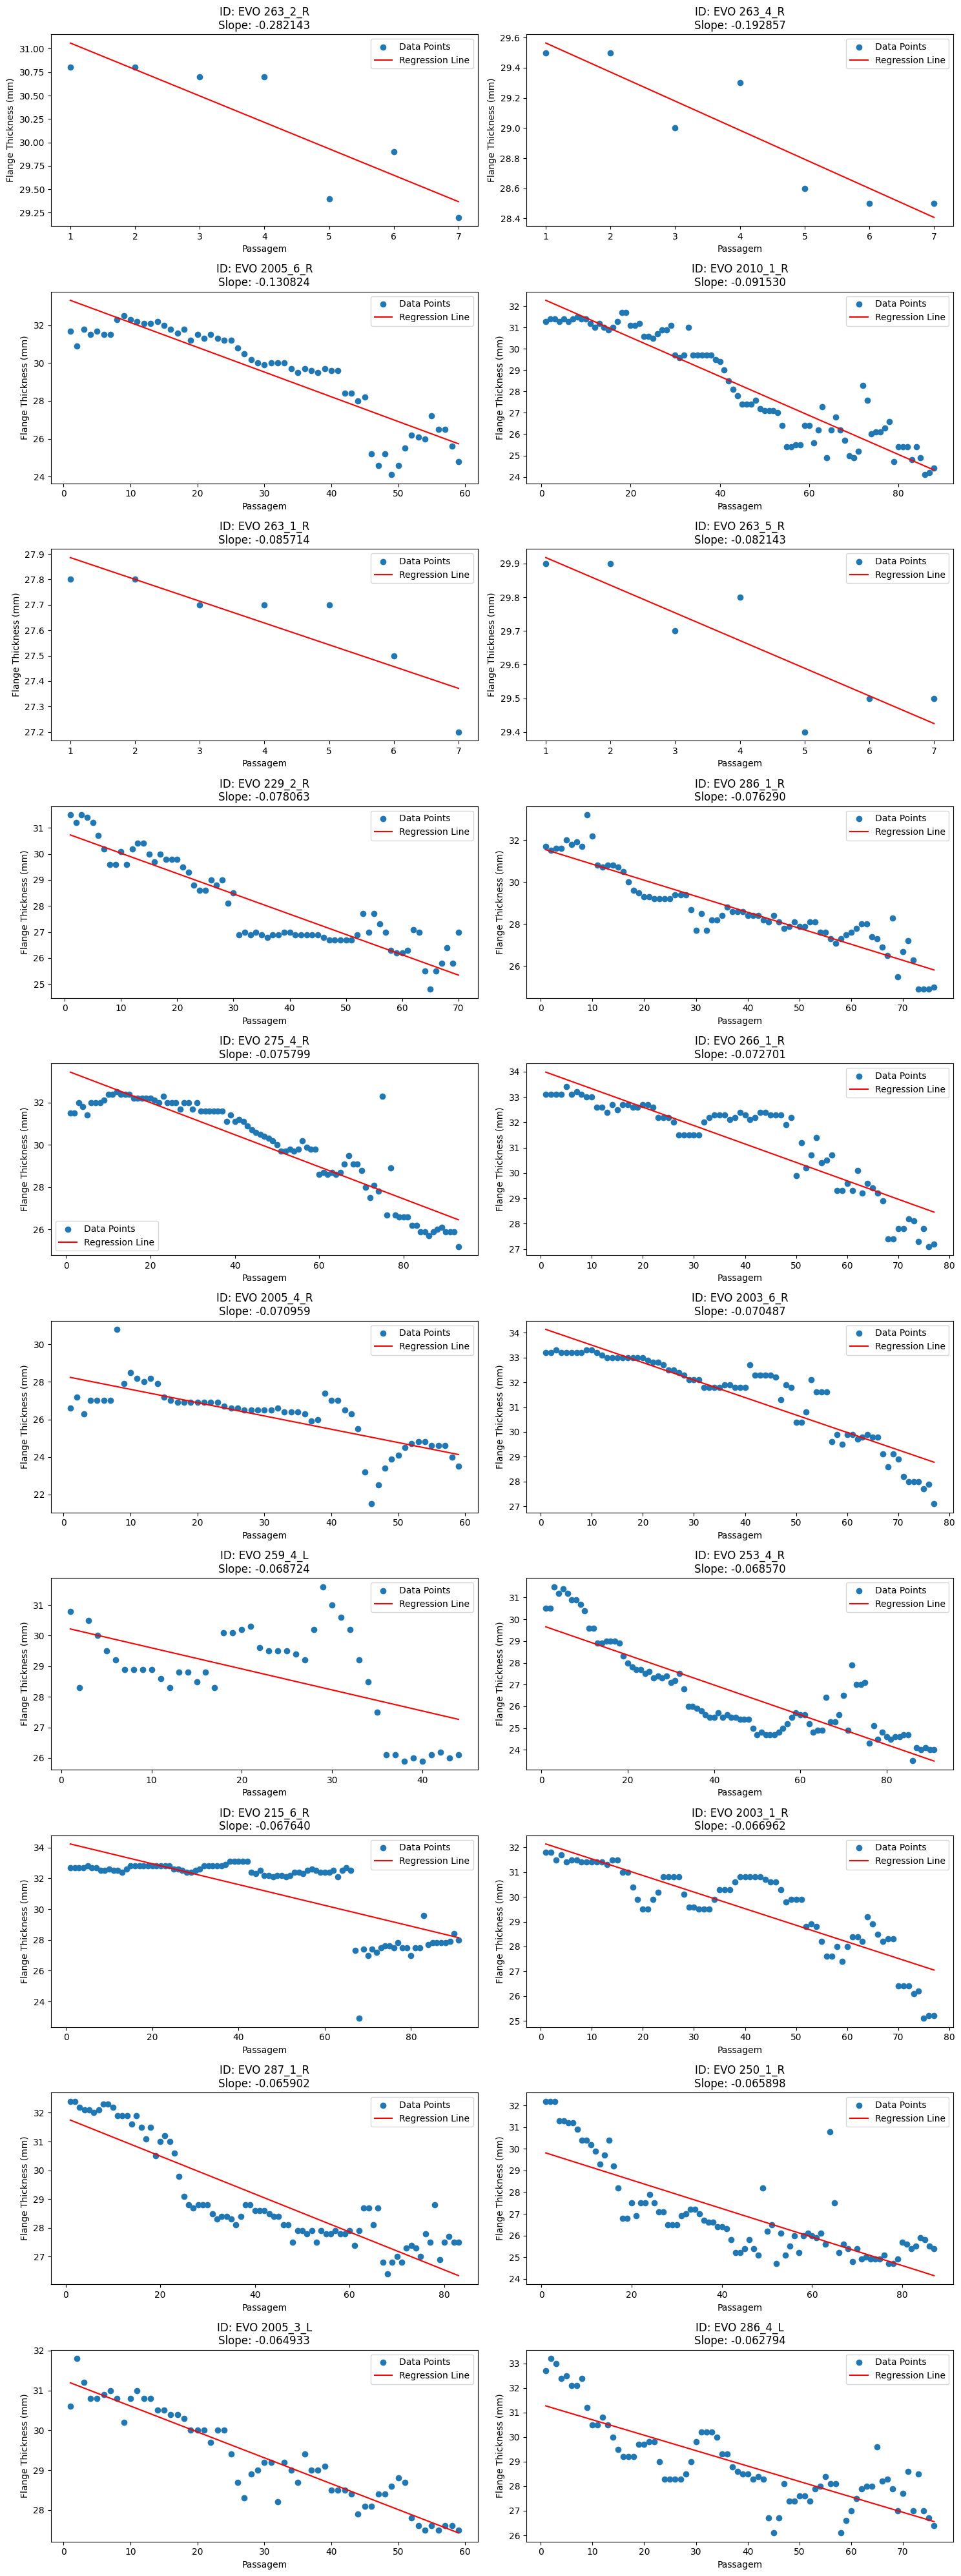

In [ ]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt



# Função para ajustar uma linha de regressão e retornar a inclinação
def calculate_regression_slope(group):
    X = sm.add_constant(group['passagem'])
    y = group['Flange Thickness (mm)']
    model = sm.OLS(y, X).fit()
    slope = model.params['passagem']
    return pd.Series({
        'Regression Slope': slope,
        'Intercept': model.params['const']
    })

# Aplicar a função para cada grupo de 'id'
regression_slope_df = df_final.groupby('id').apply(calculate_regression_slope).reset_index()

# Ordenar os IDs pela maior inclinação (negativa) da regressão
regression_slope_df_sorted = regression_slope_df.sort_values(by='Regression Slope', ascending=True)

# Exibir os 20 IDs com a maior taxa de degradação (maior inclinação negativa)
top_20_regression_slope = regression_slope_df_sorted.head(20)
print(top_20_regression_slope)

# Plotar as linhas de regressão para os 20 IDs com a maior taxa de degradação
fig, axs = plt.subplots(10, 2, figsize=(15, 40))
axs = axs.flatten()

for ax, (i, row) in zip(axs, top_20_regression_slope.iterrows()):
    specific_id = row['id']
    intercept = row['Intercept']
    slope = row['Regression Slope']

    df_specific_id = df_final[df_final['id'] == specific_id]
    X = df_specific_id['passagem']
    y = df_specific_id['Flange Thickness (mm)']

    ax.scatter(X, y, label='Data Points')
    ax.plot(X, intercept + slope * X, color='red', label='Regression Line')
    ax.set_title(f"ID: {specific_id}\nSlope: {slope:.6f}")
    ax.set_xlabel('Passagem')
    ax.set_ylabel('Flange Thickness (mm)')
    ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
df_final_specific = df_final[df_final['id'] == 'EVO 213_5_R']

# Mostrar as primeiras linhas do dataframe filtrado para verificação
df_final_specific.head()


,Train Time,Vehicle Tag,Vehicle Axle Number,Side of Vehicle,Site,Flange Thickness (mm),Flange Thickness Confidence,Flange Height (mm),Flange Height Confidence,Rim Thickness (mm),Rim Thickness Confidence,Tread Hollow (mm),Tread Hollow Confidence,Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm),Date REF,id,passagem
19509,2023-07-17 10:44:22,EVO 213,5,R,16K888 Lina 1,33.8,Yes,25.4,Yes,35.9,Yes,0.0,Yes,5.4,1513.6,1012.0,43.0,AM,EVO 213_5_R,1
18321,2023-07-20 13:29:36,EVO 213,5,R,16K888 Lina 1,33.2,Yes,27.6,Yes,34.8,Yes,0.0,NaN,3.1,1514.2,1009.0,37.1,PM,EVO 213_5_R,2
17661,2023-07-21 03:59:01,EVO 213,5,R,16K888 Lina 2,33.5,NaN,26.5,NaN,35.3,NaN,0.0,NaN,4.2,1513.9,1010.5,40.0,AM,EVO 213_5_R,3
16473,2023-07-24 15:02:31,EVO 213,5,R,16K888 Lina 1,33.5,No,26.5,Yes,35.3,Yes,0.0,NaN,4.2,1513.9,1010.5,40.0,PM,EVO 213_5_R,4
15081,2023-07-27 09:44:23,EVO 213,5,R,16K888 Lina 2,33.3,NaN,27.2,NaN,34.9,NaN,0.0,NaN,3.1,1514.0,1009.1,36.9,AM,EVO 213_5_R,5


In [ ]:
df_final_specific = df_final_specific.drop(['Vehicle Tag','Vehicle Axle Number','Side of Vehicle','Site','Flange Height Confidence','Flange Thickness Confidence','Rim Thickness Confidence','Tread Hollow Confidence','Date REF'], axis=1)
df_final_specific

,Train Time,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm),id,passagem
19509,2023-07-17 10:44:22,33.8,25.4,35.9,0.0,5.4,1513.6,1012.0,43.0,EVO 213_5_R,1
18321,2023-07-20 13:29:36,33.2,27.6,34.8,0.0,3.1,1514.2,1009.0,37.1,EVO 213_5_R,2
17661,2023-07-21 03:59:01,33.5,26.5,35.3,0.0,4.2,1513.9,1010.5,40.0,EVO 213_5_R,3
16473,2023-07-24 15:02:31,33.5,26.5,35.3,0.0,4.2,1513.9,1010.5,40.0,EVO 213_5_R,4
15081,2023-07-27 09:44:23,33.3,27.2,34.9,0.0,3.1,1514.0,1009.1,36.9,EVO 213_5_R,5
...,...,...,...,...,...,...,...,...,...,...,...
23497,2024-04-28 09:03:09,26.9,32.1,32.2,2.0,1.9,1519.3,1003.0,27.0,EVO 213_5_R,83
23281,2024-04-29 04:39:54,26.8,32.1,32.2,2.0,1.9,1516.8,1006.6,31.0,EVO 213_5_R,84
76789,2024-05-02 21:57:00,26.8,32.0,32.0,2.3,1.4,1518.0,1004.0,30.4,EVO 213_5_R,85
21229,2024-05-21 23:31:00,26.8,32.0,32.1,2.1,1.7,1518.0,1004.5,29.4,EVO 213_5_R,86


In [ ]:

import numpy as np


df_final_specific['MM5d'] = df_final_specific['Flange Thickness (mm)'].rolling(window=5).mean().round(2)
df_final_specific['MM10d'] = df_final_specific['Flange Thickness (mm)'].rolling(window=10).mean().round(2)
df_final_specific['MM30d'] = df_final_specific['Flange Thickness (mm)'].rolling(window=30).mean().round(2)

#mudança percentual na espessura da flange em relação ao valor anterior. Esta coluna pode ser usada como uma feature para prever a degradação
df_final_specific['Flange_Thickness_Change'] = df_final_specific['Flange Thickness (mm)'].pct_change()

# Substitui os valores infinitos (causados pela divisão por zero) por NaN
df_final_specific['Flange_Thickness_Change'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Supondo que df_final_specific já está definido
df_final_specific['Flange_Thickness_Change'].fillna(0, inplace=True)
df_final_specific['MM5d'].fillna(df_final_specific['Flange Thickness (mm)'], inplace=True)
df_final_specific['MM10d'].fillna(df_final_specific['Flange Thickness (mm)'], inplace=True)
df_final_specific['MM30d'].fillna(df_final_specific['Flange Thickness (mm)'], inplace=True)

df_final_specific.head(31)

,Train Time,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm),id,passagem,MM5d,MM10d,MM30d,Flange_Thickness_Change
19509,2023-07-17 10:44:22,33.8,25.4,35.9,0.0,5.4,1513.6,1012.0,43.0,EVO 213_5_R,1,33.80,33.80,33.80,0.000000
18321,2023-07-20 13:29:36,33.2,27.6,34.8,0.0,3.1,1514.2,1009.0,37.1,EVO 213_5_R,2,33.20,33.20,33.20,-0.017751
17661,2023-07-21 03:59:01,33.5,26.5,35.3,0.0,4.2,1513.9,1010.5,40.0,EVO 213_5_R,3,33.50,33.50,33.50,0.009036
16473,2023-07-24 15:02:31,33.5,26.5,35.3,0.0,4.2,1513.9,1010.5,40.0,EVO 213_5_R,4,33.50,33.50,33.50,0.000000
15081,2023-07-27 09:44:23,33.3,27.2,34.9,0.0,3.1,1514.0,1009.1,36.9,EVO 213_5_R,5,33.46,33.30,33.30,-0.005970
14253,2023-07-30 03:59:52,32.1,28.0,34.6,0.0,2.8,1515.3,1010.0,37.6,EVO 213_5_R,6,33.12,32.10,32.10,-0.036036
96565,2023-08-03 04:07:00,31.0,28.1,34.8,0.0,1.6,1514.8,1012.0,46.0,EVO 213_5_R,7,32.68,31.00,31.00,-0.034268
90961,2023-08-06 05:58:00,30.5,28.2,34.6,0.0,2.2,1515.6,1008.0,38.2,EVO 213_5_R,8,32.08,30.50,30.50,-0.016129
82849,2023-08-11 02:23:00,29.3,29.1,34.0,0.0,1.5,1515.9,1007.0,38.5,EVO 213_5_R,9,31.24,29.30,29.30,-0.039344
12741,2023-08-14 09:38:27,29.2,29.1,34.0,0.0,1.9,1515.8,1008.0,38.2,EVO 213_5_R,10,30.42,31.94,29.20,-0.003413


In [ ]:
# Primeiro, agrupe os dados por 'id'
groups = df_final_specific.groupby('id')

# Em seguida, defina uma função para calcular a degradação por passagem
def calculate_degradation(row, first_value):
    return ( row['Flange Thickness (mm)'] - first_value) / row['passagem']

# Agora, aplique essa função a cada grupo
for name, group in groups:
    first_value = group.iloc[0]['Flange Thickness (mm)']
    df_final_specific.loc[group.index, 'Degradation per Passage'] = group.apply(calculate_degradation, axis=1, first_value=first_value)
display(df_final_specific)


,Train Time,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm),id,passagem,MM5d,MM10d,MM30d,Flange_Thickness_Change,Degradation per Passage
19509,2023-07-17 10:44:22,33.8,25.4,35.9,0.0,5.4,1513.6,1012.0,43.0,EVO 213_5_R,1,33.80,33.80,33.80,0.000000,0.000000
18321,2023-07-20 13:29:36,33.2,27.6,34.8,0.0,3.1,1514.2,1009.0,37.1,EVO 213_5_R,2,33.20,33.20,33.20,-0.017751,-0.300000
17661,2023-07-21 03:59:01,33.5,26.5,35.3,0.0,4.2,1513.9,1010.5,40.0,EVO 213_5_R,3,33.50,33.50,33.50,0.009036,-0.100000
16473,2023-07-24 15:02:31,33.5,26.5,35.3,0.0,4.2,1513.9,1010.5,40.0,EVO 213_5_R,4,33.50,33.50,33.50,0.000000,-0.075000
15081,2023-07-27 09:44:23,33.3,27.2,34.9,0.0,3.1,1514.0,1009.1,36.9,EVO 213_5_R,5,33.46,33.30,33.30,-0.005970,-0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23497,2024-04-28 09:03:09,26.9,32.1,32.2,2.0,1.9,1519.3,1003.0,27.0,EVO 213_5_R,83,27.00,27.25,27.40,0.003731,-0.083133
23281,2024-04-29 04:39:54,26.8,32.1,32.2,2.0,1.9,1516.8,1006.6,31.0,EVO 213_5_R,84,26.94,27.15,27.41,-0.003717,-0.083333
76789,2024-05-02 21:57:00,26.8,32.0,32.0,2.3,1.4,1518.0,1004.0,30.4,EVO 213_5_R,85,26.80,27.05,27.39,0.000000,-0.082353
21229,2024-05-21 23:31:00,26.8,32.0,32.1,2.1,1.7,1518.0,1004.5,29.4,EVO 213_5_R,86,26.82,27.00,27.37,0.000000,-0.081395


In [ ]:
#20 dias para validação da previção nos valores reais
#ou seja vou tirar do data frame de treinamento as ultimas 20 passagens para depois validar a previsão com os valores reais
df_prever = df_final_specific.tail(20)
df_prever

,Train Time,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm),id,passagem,MM5d,MM10d,MM30d,Flange_Thickness_Change,Degradation per Passage
33393,2024-03-13 14:28:46,26.8,30.2,32.1,2.3,2.8,1513.3,1004.0,35.7,EVO 213_5_R,68,26.58,26.96,27.20,0.007519,-0.102941
32481,2024-03-16 03:51:39,27.0,30.3,32.2,2.4,2.2,1514.8,1004.3,36.0,EVO 213_5_R,69,26.68,26.88,27.20,0.007463,-0.098551
31425,2024-03-20 17:18:10,27.2,30.3,32.2,2.3,2.7,1514.7,1004.0,33.5,EVO 213_5_R,70,26.82,26.82,27.21,0.007407,-0.094286
30525,2024-03-23 09:29:13,27.5,29.8,32.3,2.4,4.3,1515.2,1004.1,29.1,EVO 213_5_R,71,27.02,26.79,27.23,0.011029,-0.088732
29481,2024-03-26 21:23:28,27.8,28.2,34.0,2.9,3.3,1517.0,1012.0,29.1,EVO 213_5_R,72,27.26,26.89,27.26,0.010909,-0.083333
28353,2024-03-30 14:16:32,28.9,26.4,35.9,3.7,4.0,1516.7,1012.0,29.0,EVO 213_5_R,73,27.68,27.13,27.32,0.039568,-0.067123
27945,2024-03-31 06:51:36,27.8,26.6,35.9,3.5,2.6,1513.7,1009.3,32.6,EVO 213_5_R,74,27.84,27.26,27.34,-0.038062,-0.081081
74761,2024-04-04 06:21:00,27.8,26.6,33.9,3.5,2.8,1515.6,1011.1,33.1,EVO 213_5_R,75,27.96,27.39,27.35,0.000000,-0.080000
70645,2024-04-07 12:12:00,27.3,30.1,35.9,1.8,2.4,1514.2,1003.0,33.5,EVO 213_5_R,76,27.92,27.47,27.36,-0.017986,-0.085526
66609,2024-04-10 18:43:00,27.3,30.5,32.8,1.8,1.7,1518.3,1005.0,28.1,EVO 213_5_R,77,27.82,27.54,27.36,0.000000,-0.084416


In [ ]:
import pandas as pd


# Função para remover as últimas 20 linhas de cada id do data frame original que vai realizar o treinamento
def remove_last_n_rows(group, n=20):
    return group.iloc[:-n]

# Aplicar a função para o ID específico
df_df = df_final_specific.groupby('id', group_keys=False).apply(remove_last_n_rows)

# Mostrar as primeiras linhas do dataframe filtrado para verificação
display(df_df)



,Train Time,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm),id,passagem,MM5d,MM10d,MM30d,Flange_Thickness_Change,Degradation per Passage
19509,2023-07-17 10:44:22,33.8,25.4,35.9,0.0,5.4,1513.6,1012.0,43.0,EVO 213_5_R,1,33.80,33.80,33.80,0.000000,0.000000
18321,2023-07-20 13:29:36,33.2,27.6,34.8,0.0,3.1,1514.2,1009.0,37.1,EVO 213_5_R,2,33.20,33.20,33.20,-0.017751,-0.300000
17661,2023-07-21 03:59:01,33.5,26.5,35.3,0.0,4.2,1513.9,1010.5,40.0,EVO 213_5_R,3,33.50,33.50,33.50,0.009036,-0.100000
16473,2023-07-24 15:02:31,33.5,26.5,35.3,0.0,4.2,1513.9,1010.5,40.0,EVO 213_5_R,4,33.50,33.50,33.50,0.000000,-0.075000
15081,2023-07-27 09:44:23,33.3,27.2,34.9,0.0,3.1,1514.0,1009.1,36.9,EVO 213_5_R,5,33.46,33.30,33.30,-0.005970,-0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77509,2024-03-02 01:22:00,26.5,29.9,31.7,2.1,1.0,1516.8,1003.0,37.0,EVO 213_5_R,63,27.34,27.83,27.35,-0.011194,-0.115873
77317,2024-03-02 14:45:00,26.5,29.9,31.7,2.2,3.8,1512.7,1003.0,38.3,EVO 213_5_R,64,27.08,27.82,27.29,0.000000,-0.114062
73693,2024-03-05 04:20:00,26.5,30.0,31.7,2.3,1.2,1515.4,1003.0,37.2,EVO 213_5_R,65,26.82,27.72,27.25,0.000000,-0.112308
70873,2024-03-07 12:08:00,26.5,30.0,31.7,2.3,2.4,1514.9,1004.0,35.8,EVO 213_5_R,66,26.56,27.63,27.21,0.000000,-0.110606


In [ ]:
df_df['Flange Thickness (mm)'] = df_df['Flange Thickness (mm)'].shift(-20)
df_df

,Train Time,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm),id,passagem,MM5d,MM10d,MM30d,Flange_Thickness_Change,Degradation per Passage
19509,2023-07-17 10:44:22,28.3,25.4,35.9,0.0,5.4,1513.6,1012.0,43.0,EVO 213_5_R,1,33.80,33.80,33.80,0.000000,0.000000
18321,2023-07-20 13:29:36,28.1,27.6,34.8,0.0,3.1,1514.2,1009.0,37.1,EVO 213_5_R,2,33.20,33.20,33.20,-0.017751,-0.300000
17661,2023-07-21 03:59:01,28.1,26.5,35.3,0.0,4.2,1513.9,1010.5,40.0,EVO 213_5_R,3,33.50,33.50,33.50,0.009036,-0.100000
16473,2023-07-24 15:02:31,28.3,26.5,35.3,0.0,4.2,1513.9,1010.5,40.0,EVO 213_5_R,4,33.50,33.50,33.50,0.000000,-0.075000
15081,2023-07-27 09:44:23,27.8,27.2,34.9,0.0,3.1,1514.0,1009.1,36.9,EVO 213_5_R,5,33.46,33.30,33.30,-0.005970,-0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77509,2024-03-02 01:22:00,NaN,29.9,31.7,2.1,1.0,1516.8,1003.0,37.0,EVO 213_5_R,63,27.34,27.83,27.35,-0.011194,-0.115873
77317,2024-03-02 14:45:00,NaN,29.9,31.7,2.2,3.8,1512.7,1003.0,38.3,EVO 213_5_R,64,27.08,27.82,27.29,0.000000,-0.114062
73693,2024-03-05 04:20:00,NaN,30.0,31.7,2.3,1.2,1515.4,1003.0,37.2,EVO 213_5_R,65,26.82,27.72,27.25,0.000000,-0.112308
70873,2024-03-07 12:08:00,NaN,30.0,31.7,2.3,2.4,1514.9,1004.0,35.8,EVO 213_5_R,66,26.56,27.63,27.21,0.000000,-0.110606


In [ ]:
# Remover valores nulos na coluna 'Flange Thickness (mm)'
df_df = df_df.dropna(subset=['Flange Thickness (mm)'])

display(df_df)

,Train Time,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm),id,passagem,MM5d,MM10d,MM30d,Flange_Thickness_Change,Degradation per Passage
19509,2023-07-17 10:44:22,28.3,25.4,35.9,0.0,5.4,1513.6,1012.0,43.0,EVO 213_5_R,1,33.80,33.80,33.80,0.000000,0.000000
18321,2023-07-20 13:29:36,28.1,27.6,34.8,0.0,3.1,1514.2,1009.0,37.1,EVO 213_5_R,2,33.20,33.20,33.20,-0.017751,-0.300000
17661,2023-07-21 03:59:01,28.1,26.5,35.3,0.0,4.2,1513.9,1010.5,40.0,EVO 213_5_R,3,33.50,33.50,33.50,0.009036,-0.100000
16473,2023-07-24 15:02:31,28.3,26.5,35.3,0.0,4.2,1513.9,1010.5,40.0,EVO 213_5_R,4,33.50,33.50,33.50,0.000000,-0.075000
15081,2023-07-27 09:44:23,27.8,27.2,34.9,0.0,3.1,1514.0,1009.1,36.9,EVO 213_5_R,5,33.46,33.30,33.30,-0.005970,-0.100000
14253,2023-07-30 03:59:52,27.4,28.0,34.6,0.0,2.8,1515.3,1010.0,37.6,EVO 213_5_R,6,33.12,32.10,32.10,-0.036036,-0.283333
96565,2023-08-03 04:07:00,27.0,28.1,34.8,0.0,1.6,1514.8,1012.0,46.0,EVO 213_5_R,7,32.68,31.00,31.00,-0.034268,-0.400000
90961,2023-08-06 05:58:00,27.0,28.2,34.6,0.0,2.2,1515.6,1008.0,38.2,EVO 213_5_R,8,32.08,30.50,30.50,-0.016129,-0.412500
82849,2023-08-11 02:23:00,27.9,29.1,34.0,0.0,1.5,1515.9,1007.0,38.5,EVO 213_5_R,9,31.24,29.30,29.30,-0.039344,-0.500000
12741,2023-08-14 09:38:27,27.8,29.1,34.0,0.0,1.9,1515.8,1008.0,38.2,EVO 213_5_R,10,30.42,31.94,29.20,-0.003413,-0.460000


In [ ]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_regression
# Selecionar as features e a variável alvo
X = df_df[['passagem', 'Flange Height (mm)', 'Rim Thickness (mm)', 'Tread Hollow (mm)',
           'Flange Slope (mm)', 'BTB (mm)', 'Wheel Diameter (mm)', 'Rail Dist (mm)','Flange_Thickness_Change','Degradation per Passage','MM5d','MM10d','MM30d']]
y = df_df['Flange Thickness (mm)']

# Usar SelectKBest para selecionar as melhores features
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X, y)
scores = selector.scores_

# Criar um DataFrame com as features e seus respectivos scores
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

# Mostrar as melhores features
display(feature_scores)

,Feature,Score
1,Flange Height (mm),6.769195
6,Wheel Diameter (mm),6.157265
11,MM10d,5.905116
2,Rim Thickness (mm),5.175762
12,MM30d,4.442009
10,MM5d,4.262551
3,Tread Hollow (mm),3.524476
0,passagem,3.133491
8,Flange_Thickness_Change,2.407234
4,Flange Slope (mm),1.044469


In [ ]:
df_df = df_df.drop(['Train Time','Flange_Thickness_Change','BTB (mm)','Rail Dist (mm)'], axis=1)
df_df

,Flange Thickness (mm),Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),Wheel Diameter (mm),id,passagem,MM5d,MM10d,MM30d,Degradation per Passage
19509,28.3,25.4,35.9,0.0,5.4,1012.0,EVO 213_5_R,1,33.80,33.80,33.80,0.000000
18321,28.1,27.6,34.8,0.0,3.1,1009.0,EVO 213_5_R,2,33.20,33.20,33.20,-0.300000
17661,28.1,26.5,35.3,0.0,4.2,1010.5,EVO 213_5_R,3,33.50,33.50,33.50,-0.100000
16473,28.3,26.5,35.3,0.0,4.2,1010.5,EVO 213_5_R,4,33.50,33.50,33.50,-0.075000
15081,27.8,27.2,34.9,0.0,3.1,1009.1,EVO 213_5_R,5,33.46,33.30,33.30,-0.100000
14253,27.4,28.0,34.6,0.0,2.8,1010.0,EVO 213_5_R,6,33.12,32.10,32.10,-0.283333
96565,27.0,28.1,34.8,0.0,1.6,1012.0,EVO 213_5_R,7,32.68,31.00,31.00,-0.400000
90961,27.0,28.2,34.6,0.0,2.2,1008.0,EVO 213_5_R,8,32.08,30.50,30.50,-0.412500
82849,27.9,29.1,34.0,0.0,1.5,1007.0,EVO 213_5_R,9,31.24,29.30,29.30,-0.500000
12741,27.8,29.1,34.0,0.0,1.9,1008.0,EVO 213_5_R,10,30.42,31.94,29.20,-0.460000


In [ ]:
#import regression lib pycaret
from pycaret.regression import *
setup(data = df_df, target= 'Flange Thickness (mm)', session_id=12)

,Description,Value
0,Session id,12
1,Target,Flange Thickness (mm)
2,Target type,Regression
3,Original data shape,"(47, 12)"
4,Transformed data shape,"(47, 12)"
5,Transformed train set shape,"(32, 12)"
6,Transformed test set shape,"(15, 12)"
7,Numeric features,10
8,Categorical features,1
9,Preprocess,True


In [ ]:
top3 = compare_models(n_select=3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,0.4563,0.6967,0.5573,0.0143,0.0191,0.0160,0.1110
knn,K Neighbors Regressor,0.4942,0.9063,0.6362,-0.0189,0.0218,0.0173,0.1050
huber,Huber Regressor,0.5108,0.9581,0.6097,-0.0574,0.0210,0.0178,0.1620
ada,AdaBoost Regressor,0.5250,0.7883,0.6518,-0.1980,0.0224,0.0185,0.1390
et,Extra Trees Regressor,0.5156,0.8047,0.6336,-0.2000,0.0218,0.0182,0.1580
gbr,Gradient Boosting Regressor,0.5181,0.8701,0.6608,-0.2432,0.0227,0.0182,0.1100
omp,Orthogonal Matching Pursuit,0.6231,1.0285,0.7282,-0.2777,0.0252,0.0221,0.0640
en,Elastic Net,0.6382,1.0292,0.7394,-0.2909,0.0256,0.0226,0.0630
lasso,Lasso Regression,0.6531,1.0329,0.7513,-0.3140,0.0260,0.0232,0.0650
llar,Lasso Least Angle Regression,0.6531,1.0329,0.7513,-0.3140,0.0260,0.0232,0.0650


Processing:   0%|          | 0/83 [00:00<?, ?it/s]

In [ ]:
et = create_model('et', fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4100,0.2857,0.5345,-0.6826,0.0189,0.0153
1,0.9739,2.6819,1.6376,-0.2136,0.0544,0.0326
2,0.2685,0.1131,0.3363,0.6758,0.0118,0.0098
3,0.3612,0.1950,0.4416,-0.1603,0.0154,0.0131
4,0.3683,0.2353,0.4851,0.4186,0.0171,0.0135
Mean,0.4764,0.7022,0.6870,0.0076,0.0235,0.0168
Std,0.2530,0.9914,0.4798,0.4835,0.0156,0.0081


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
#tunando o modelo para evitar overfiting

et_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'ccp_alpha': [0.0, 0.01, 0.02, 0.05]
}

tunne_et = tune_model(et, n_iter =1000, optimize='RMSE', custom_grid=et_params, fold=5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.3691,0.2091,0.4573,-0.2316,0.0162,0.0138
1,0.9534,2.6575,1.6302,-0.2026,0.0541,0.0318
2,0.2581,0.0827,0.2876,0.7628,0.0101,0.0093
3,0.3146,0.1622,0.4027,0.0349,0.0141,0.0113
4,0.3121,0.1719,0.4146,0.5753,0.0146,0.0115
Mean,0.4415,0.6567,0.6385,0.1878,0.0218,0.0155
Std,0.2584,1.0013,0.4990,0.4080,0.0163,0.0083


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 972 candidates, totalling 4860 fits


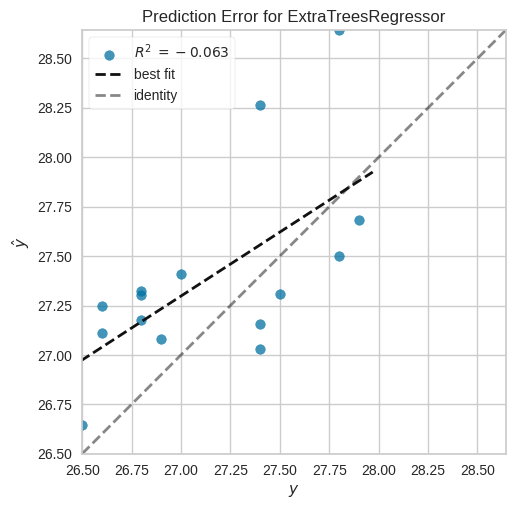

In [ ]:
#Gráfico de erros
plot_model(tunne_et, plot='error')

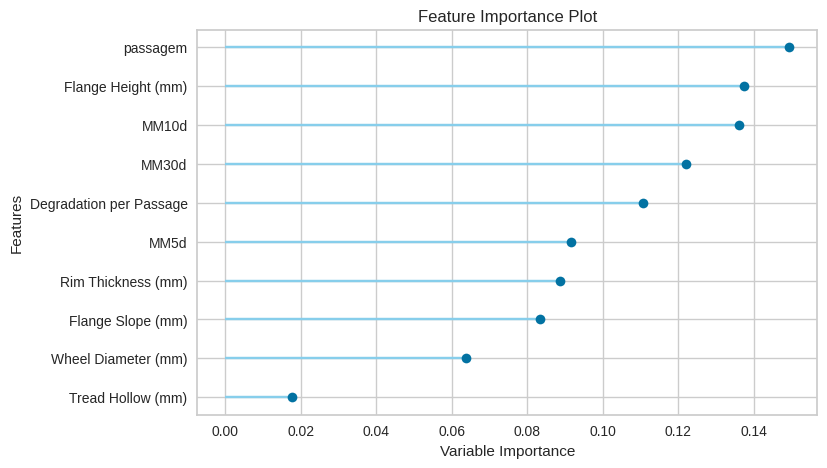

In [ ]:
plot_model(tunne_et, plot='feature')

In [ ]:
#testando a previsão com os dados de teste
predict_model(tunne_et)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.4217,0.2267,0.4761,-0.0634,0.0167,0.0155


,Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),Wheel Diameter (mm),id,passagem,MM5d,MM10d,MM30d,Degradation per Passage,Flange Thickness (mm),prediction_label
86533,29.400000,33.599998,0.0,2.1,1008.0,EVO 213_5_R,24,28.240000,28.410000,28.299999,-0.229167,27.400000,27.154755
87481,28.799999,34.299999,0.0,0.9,1008.0,EVO 213_5_R,44,27.040001,27.129999,27.730000,-0.145455,26.500000,26.647005
90961,28.200001,34.599998,0.0,2.2,1008.0,EVO 213_5_R,8,32.080002,30.500000,30.500000,-0.412500,27.000000,27.409286
46797,28.799999,34.099998,0.0,0.9,1008.0,EVO 213_5_R,39,27.219999,27.540001,28.100000,-0.176923,27.799999,28.642917
91765,30.000000,33.200001,0.4,2.8,1007.0,EVO 213_5_R,34,27.860001,27.639999,28.770000,-0.161765,26.600000,27.112979
86293,29.400000,33.599998,0.0,2.4,1007.0,EVO 213_5_R,25,28.120001,28.290001,27.799999,-0.240000,27.400000,27.030634
53889,29.600000,33.500000,0.3,2.5,1008.0,EVO 213_5_R,30,27.420000,27.770000,29.520000,-0.200000,26.600000,27.247869
46617,28.799999,34.200001,0.0,2.8,1008.0,EVO 213_5_R,40,27.020000,27.450001,28.020000,-0.172500,27.799999,27.502954
5073,28.500000,34.099998,0.0,1.7,1008.0,EVO 213_5_R,18,28.740000,29.020000,28.400000,-0.300000,26.799999,27.322079
53565,29.600000,33.299999,0.3,2.3,1005.0,EVO 213_5_R,31,27.480000,27.709999,29.309999,-0.196774,26.799999,27.175981


In [ ]:
#finalizar o modelo
final_et_model= finalize_model(tunne_et)

In [ ]:
#INFORMAÇÃO IMPORTANTE QUANDO ENTRAR OS NOVOS VALORES PARA O DATA FRAME ORIGINAL QUE É O df_df ANTES DE ENTRAR OS NOVOS VALORES ELE PRECISA RETORNAR O SHIFT PARA (0) PARA NORMALIZAR A BASE
#PARA AI SIM DEPOIS DAR O SHIFT DA QUANTIADADE DE DIA QUE EU QUERO PREVER COM OS NOVOS VALORES QUE ENTROU
#OBS : PARA CADA FEATURES ATUAL EU TENHO O RESULTADO DO MEU VALOR DE AMANHÃ
prev = predict_model(final_et_model, data=df_prever)
prev

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.3337,0.2257,0.4751,0.1778,0.0165,0.0120


,Train Time,Flange Height (mm),Rim Thickness (mm),Tread Hollow (mm),Flange Slope (mm),BTB (mm),Wheel Diameter (mm),Rail Dist (mm),id,passagem,MM5d,MM10d,MM30d,Flange_Thickness_Change,Degradation per Passage,Flange Thickness (mm),prediction_label
33393,2024-03-13 14:28:46,30.200001,32.099998,2.3,2.8,1513.300049,1004.000000,35.700001,EVO 213_5_R,68,26.580000,26.959999,27.200001,0.007519,-0.102941,26.799999,26.881995
32481,2024-03-16 03:51:39,30.299999,32.200001,2.4,2.2,1514.800049,1004.299988,36.000000,EVO 213_5_R,69,26.680000,26.879999,27.200001,0.007463,-0.098551,27.000000,26.884134
31425,2024-03-20 17:18:10,30.299999,32.200001,2.3,2.7,1514.699951,1004.000000,33.500000,EVO 213_5_R,70,26.820000,26.820000,27.209999,0.007407,-0.094286,27.200001,26.881995
30525,2024-03-23 09:29:13,29.799999,32.299999,2.4,4.3,1515.199951,1004.099976,29.100000,EVO 213_5_R,71,27.020000,26.790001,27.230000,0.011029,-0.088732,27.500000,26.910274
29481,2024-03-26 21:23:28,28.200001,34.000000,2.9,3.3,1517.000000,1012.000000,29.100000,EVO 213_5_R,72,27.260000,26.889999,27.260000,0.010909,-0.083333,27.799999,27.173802
28353,2024-03-30 14:16:32,26.400000,35.900002,3.7,4.0,1516.699951,1012.000000,29.000000,EVO 213_5_R,73,27.680000,27.129999,27.320000,0.039568,-0.067123,28.900000,27.332031
27945,2024-03-31 06:51:36,26.600000,35.900002,3.5,2.6,1513.699951,1009.299988,32.599998,EVO 213_5_R,74,27.840000,27.260000,27.340000,-0.038062,-0.081081,27.799999,27.335116
74761,2024-04-04 06:21:00,26.600000,33.900002,3.5,2.8,1515.599976,1011.099976,33.099998,EVO 213_5_R,75,27.959999,27.389999,27.350000,0.000000,-0.080000,27.799999,27.382110
70645,2024-04-07 12:12:00,30.100000,35.900002,1.8,2.4,1514.199951,1003.000000,33.500000,EVO 213_5_R,76,27.920000,27.469999,27.360001,-0.017986,-0.085526,27.299999,26.948888
66609,2024-04-10 18:43:00,30.500000,32.799999,1.8,1.7,1518.300049,1005.000000,28.100000,EVO 213_5_R,77,27.820000,27.540001,27.360001,0.000000,-0.084416,27.299999,26.931874


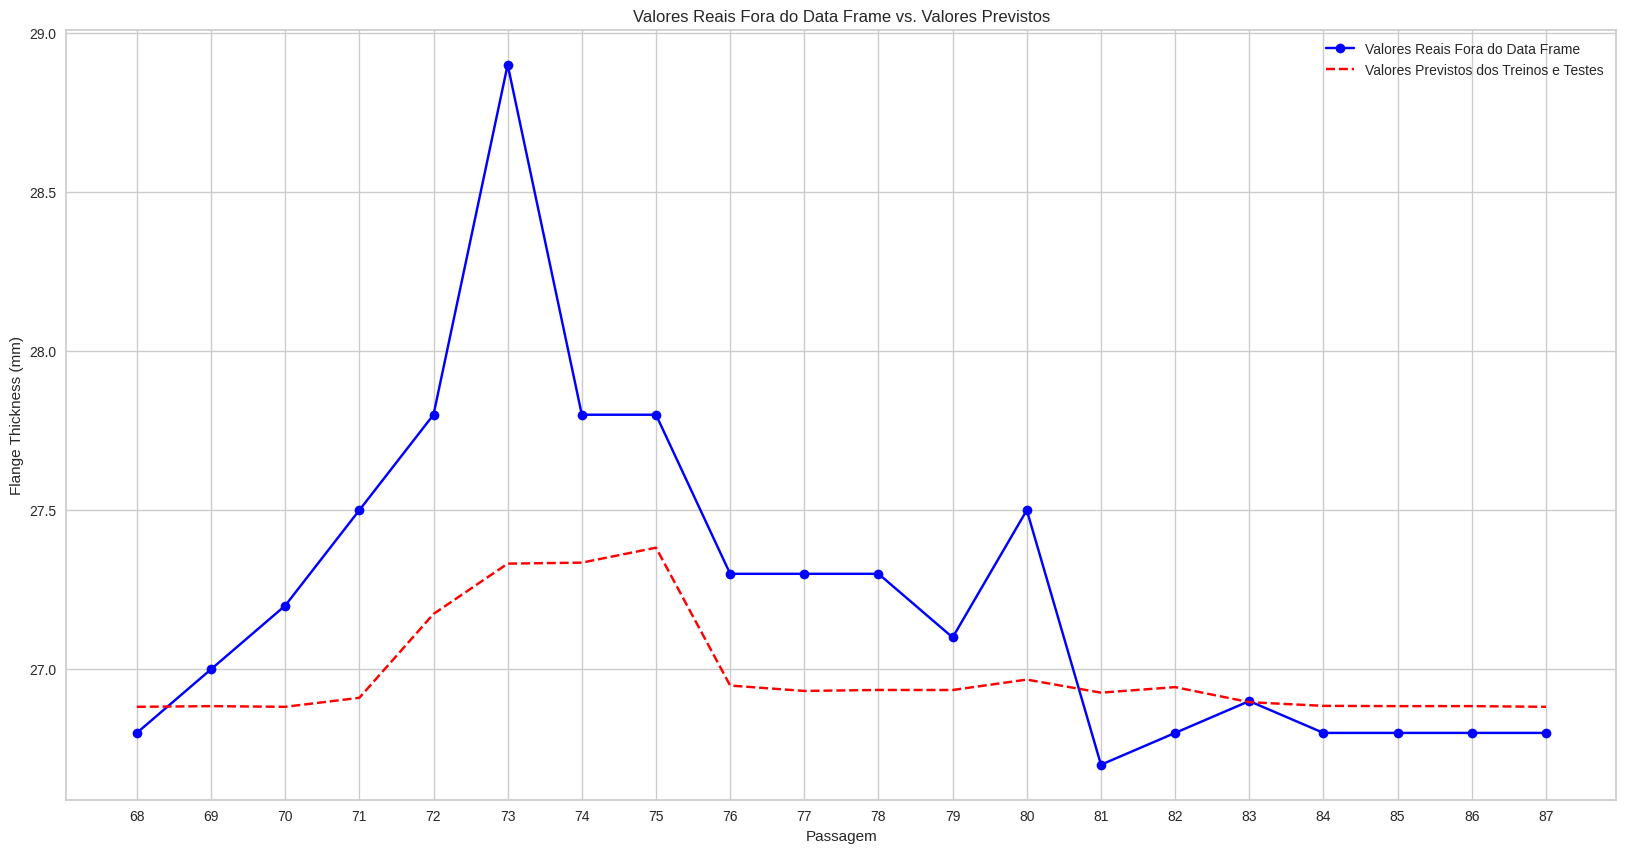

In [ ]:
# Extraia os valores do DataFrame e converta 'passagem' para inteiros
x = prev['passagem'].astype(int)
y_real = prev['Flange Thickness (mm)']
y_pred = prev['prediction_label']

# Crie o gráfico
plt.figure(figsize=(20, 10))

# Plotar os valores reais
plt.plot(x, y_real, marker='o', color='blue', linestyle='-', label='Valores Reais Fora do Data Frame')

# Plotar os valores previstos
plt.plot(x, y_pred, marker='x', color='red', linestyle='--', label='Valores Previstos dos Treinos e Testes')

# Adicione títulos e rótulos aos eixos
plt.title('Valores Reais Fora do Data Frame vs. Valores Previstos')
plt.xlabel('Passagem')
plt.ylabel('Flange Thickness (mm)')
plt.xticks(x)  # Garante que os valores do eixo x sejam exibidos como inteiros
plt.legend()

# Mostre o gráfico
plt.show()
